In [1]:
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt

#gather all the informtion form the driving_log.csv file
lines = []
with open('/data/driving_log.csv') as f:
    reader = csv.reader(f)
    for row in reader:
        lines.append(row)
        
#create variables to store images and steering angles
measurements = []
images = []
for line in lines:
    
    #grab center images
    im_path = line[0]
    file_name = im_path.split('\\')[-1]
    file_path = '/data/IMG/' + file_name
    img = cv2.imread(file_path)
    rgb_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(rgb_image)
    
    #grab measurements
    m = float(line[3])
    measurements.append(m)
    
x_train = np.array(images)
y_train = np.array(measurements)


In [2]:
#making sure the data looks good
print('training data shape: {}'.format(x_train.shape))
print('steering angles shape: {}'.format(y_train.shape))

training data shape: (13411, 160, 320, 3)
steering angles shape: (13411,)


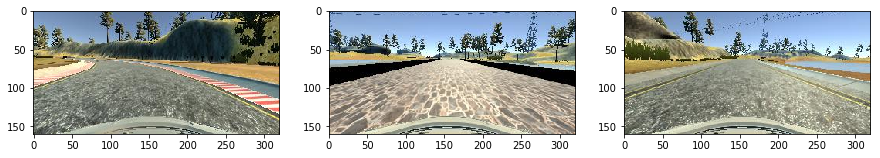

In [3]:
#visualize some images
%matplotlib inline

fig = plt.figure(figsize = (15, 40))

img1 = fig.add_subplot(1, 3, 1)
img1.imshow(x_train[0])

img2 = fig.add_subplot(1, 3, 2)
img2.imshow(x_train[1000])

img3 = fig.add_subplot(1, 3, 3)
img3.imshow(x_train[12567])

In [4]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#shuffle data
x_train, y_train = shuffle(x_train, y_train)

#define generator function for training
def generator(x, y, batch_size = 32):
    
    while 1:
        for ii in range(0, len(x), batch_size):
            
            batch_x, batch_y = x[ii:ii+batch_size], y[ii:ii+batch_size]
            yield shuffle(batch_x, batch_y)
            
#split data into training and validation steps
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

In [5]:
print('training sizes: x={}... y={}'.format(x_train.shape, y_train.shape))
print('validation sizes: x={}...y={}'.format(x_val.shape, y_val.shape))

training sizes: x=(10728, 160, 320, 3)... y=(10728,)
validation sizes: x=(2683, 160, 320, 3)...y=(2683,)


In [6]:
#create generators
train_generator = generator(x_train, y_train)
validation_generator = generator(x_val, y_val)

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Lambda, Dense, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

Using TensorFlow backend.


In [8]:
#create and train model
model = Sequential()
model.add(Lambda(lambda x: (x / 255) - 0.5, input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping = ((70,25), (0,0))))
model.add(Convolution2D(16, 5, 5, activation = 'relu'))
model.add(Convolution2D(32, 5, 5, activation = 'relu'))
model.add(Convolution2D(64, 5, 5, activation = 'relu'))
model.add(Convolution2D(128, 5, 5, activation = 'relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss= 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch=len(x_train), 
                    validation_data = validation_generator, nb_val_samples = len(x_val), nb_epoch=5, verbose=1)

#save model
model.save('model.h5')

Epoch 1/5
10728/10728 [==============================] - 311s - loss: 9.6231 - val_loss: 0.0522
Epoch 2/5
10728/10728 [==============================] - 302s - loss: 0.0535 - val_loss: 0.0522
Epoch 3/5
10728/10728 [==============================] - 301s - loss: 0.0534 - val_loss: 0.0522
Epoch 4/5
10728/10728 [==============================] - 301s - loss: 0.0534 - val_loss: 0.0522
Epoch 5/5
10728/10728 [==============================] - 301s - loss: 0.0534 - val_loss: 0.0522
